In [1]:
#IMPORT  REQUIRED LIBRARIES 
import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import pandas as pd
import os
import sys
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
import tensorflow as tf

/home/ebinjosemathew/.local/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [ ]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = '/home/ebinjosemathew/Desktop/data-science-bowl-2018/content/stage1_train'
TEST_PATH = '/home/ebinjosemathew/Desktop/data-science-bowl-2018/content/stage1_test'
epochs=50
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed
mean_iou = tf.keras.metrics.MeanIoU(num_classes=2)

In [2]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [3]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [5]:
#importing trainning data
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    
    path = TRAIN_PATH+"/" + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
   
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1),dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file, 0)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)

    Y_train[n]=mask
    if n==30:
        break
print("Done")

  4%|▍         | 30/670 [00:15<05:32,  1.92it/s]

Done


In [6]:
#importing testing data 
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH +"/"+ id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img
    if n==30:
        break
print('Done!')

Getting and resizing test images ... 


 46%|████▌     | 30/65 [00:00<00:01, 30.11it/s]

Done!


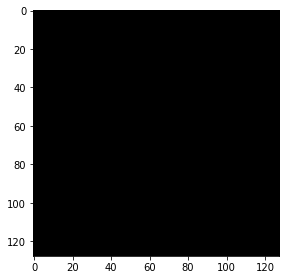

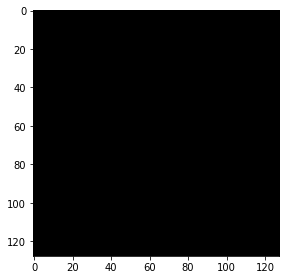

In [8]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [7]:
from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

In [8]:
#intializing the model
input_layer = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
s = Lambda(lambda x: x / 255) (input_layer)
start_neurons =16 

conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(s)
conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
pool1 = MaxPooling2D((2, 2))(conv1)
pool1 = Dropout(0.25)(pool1)

conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
pool2 = MaxPooling2D((2, 2))(conv2)
pool2 = Dropout(0.5)(pool2)

conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
pool3 = MaxPooling2D((2, 2))(conv3)
pool3 = Dropout(0.5)(pool3)

conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
pool4 = MaxPooling2D((2, 2))(conv4)
pool4 = Dropout(0.5)(pool4)

# Middle
convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
uconv4 = concatenate([deconv4, conv4])
uconv4 = Dropout(0.5)(uconv4)
uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
uconv3 = concatenate([deconv3, conv3])
uconv3 = Dropout(0.5)(uconv3)
uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
uconv2 = concatenate([deconv2, conv2])
uconv2 = Dropout(0.5)(uconv2)
uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
uconv1 = concatenate([deconv1, conv1])
uconv1 = Dropout(0.5)(uconv1)
uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)


output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    

model = Model(inputs=[input_layer], outputs=[output_layer])    
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[iou_coef])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
______________________________________________________________________________________________

In [9]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5)
checkpointer = ModelCheckpoint("/home/ebinjosemathew/Desktop/data-science-bowl-2018/content/checkpontier.hd5", monitor='val_loss', verbose=1, save_best_only=True)
early_stopper = EarlyStopping(monitor = 'val_loss', patience = 10)

history = model.fit(
                   X_train, Y_train,   
                    validation_split=0.1, 
                    batch_size=16,
                    epochs = epochs,
                   callbacks = [lr_reducer, checkpointer, early_stopper],
                   shuffle = True
                             )

Epoch 1/50
12/38 [========>.....................] - ETA: 38s - loss: 0.6331 - iou_coef: 0.0056

KeyboardInterrupt: 